# Libraries

In [313]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import cv2
import os
import skimage.feature as feature
from skimage.color import rgb2gray

# Part II - Corner Detection

1. ## Smoothing Filter
This function is being used to define the guassian Kernal to remove noise

In [314]:
def gaussian_kernel(h, std):
    kernel = np.zeros((h, h), dtype=np.float32)
    center = h // 2
    variance = std**2
    coeff = 1. / (2 * np.pi * variance)
    sum = 0
    for x in range(h):
        for y in range(h):
            x_ = x - center
            y_ = y - center
            kernel[x, y] = coeff * np.exp(-(x_**2 + y_**2) / (2 * variance))
            sum += kernel[x, y]
    return kernel / sum

##  Remove Noise using the Guassian Kernal defined in the previous function
To smooth the image, we convolve the guassian kernal with the image

In [315]:
def remove_noise(image, kernel_size=3, sigma=0.1):
    kernel = gaussian_kernel(kernel_size, sigma)
    return convolve(image, kernel, mode='reflect')

2. ## Sobel Gradiant
In this function, I find the gradiants (edges) of the soothed image using the Sobel Operator

In [316]:
def gradients(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Ix = convolve(image, sobel_x, mode='reflect')
    Iy = convolve(image, sobel_y, mode='reflect')
    return Ix, Iy

In [317]:
def gradient_images(image):
    # Calculate the gradient images
    gradient_x, gradient_y = gradients(image)

    # Compute the three images
    I_xx = gradient_x * gradient_x
    I_yy = gradient_y * gradient_y
    I_xy = gradient_x * gradient_y

    return I_xx, I_yy, I_xy

3. ## Corner Detection
Now that the we have obtained the gradiants of the image in each direction using the previous function, now we can find the corners using the Harris Corener detector

In [318]:
def harris_response(I_xx, I_yy, I_xy, gaussian_w=gaussian_kernel(5, 1), k=0.06):

    I_xx = convolve(I_xx, gaussian_w, mode='reflect')
    I_yy = convolve(I_yy, gaussian_w, mode='reflect')
    I_xy = convolve(I_xy, gaussian_w, mode='reflect')


    # Compute the elements of the M matrix
    det = I_xx * I_yy - I_xy * I_xy
    trace = I_xx + I_yy
    R = det - k * trace **2

    # R = M / (I_xx + I_yy + k)

    # Return the image with Harris corner response R
    return R #np.clip(R, 0, 1)


4. ## Non Max Supression

In [319]:
def non_max_suppression(R):
    filtered_coords = feature.peak.peak_local_max(
        R,
        min_distance=7, 
        threshold_rel=0.01,
        exclude_border=True, 
        )
    return filtered_coords#.tolist()


I programmed this function myself so that I can compare the results of the built in function and the self programmed function.<br><br>
 Ignore this function

In [320]:
def non_max_suppression_self(R, threshold=0.05, window_size=7):

    # Apply non-maximum suppression
    corner_list = []
    for i in range(window_size, R.shape[0] - window_size):
        for j in range(window_size, R.shape[1] - window_size):
            if R[i, j] > 0:
                patch = R[i-window_size:i+window_size+1, j-window_size:j+window_size+1]
                max_value = np.max(patch)
                if R[i, j] == max_value:
                    corner_list.append((i, j))

    return corner_list

5. ## Plotting of keypoints
Using the function that you gave us!<br><br>
Thank you for this!

In [321]:
def keypoints_vis(image, list_keypoints):
    # Repeat channels for creating color image from grayscale
    image_color = cv2.merge([image, image, image]).astype(np.uint8)

    # Add cross for each keypoint
    for keypoint in list_keypoints:
        # Please note that coordinates are inverted to follow OpenCV convention (x, y) instead of (y, x)
        cv2.drawMarker(image_color, (keypoint[1], keypoint[0]), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1, line_type=cv2.LINE_8)

    # Display image
    plt.figure(figsize=(15,10))
    plt.imshow(image_color)
    plt.axis('off')
    plt.show()


## Driver code
This function was written to check the results of the Harris Corner detector on a single image.

(1957, 2)


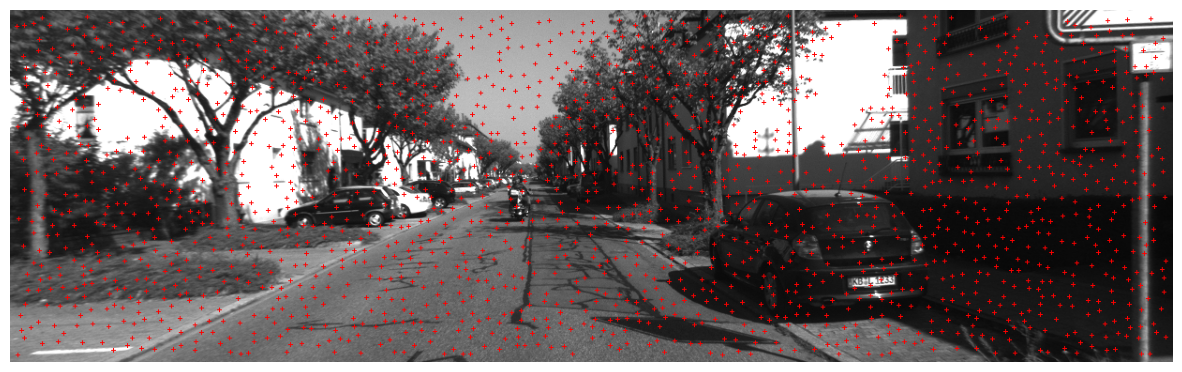

In [323]:
def test_single_image():
    image = cv2.imread('images/000000.png', cv2.IMREAD_GRAYSCALE)
    # image = rgb2gray(data.astronaut())

    # Preprocess the image to remove noise
    image = remove_noise(image)

    # Compute the gradient images
    I_xx, I_yy, I_xy = gradient_images(image)

    # Compute the Harris response
    R = harris_response(I_xx, I_yy, I_xy)
    # coordinates_ = non_max_suppression_self(R)

    # plt.imshow(R)
    # plt.show()

    # Non-maximum suppression
    coordinates = non_max_suppression(R)
    print(np.shape(coordinates))


    keypoints_vis(image, coordinates)
    # keypoints_vis(image, coordinates_)
    
test_single_image()

I made a function to read an image, convert it into a gray scale and pass it along all the functions to obtain the harris corner detectors.<br>
This function is useful later in this assignment.

In [324]:
def test_harris_detector(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess the image to remove noise
    image = remove_noise(image)

    # Compute the gradient images
    I_xx, I_yy, I_xy = gradient_images(image)

    # Compute the Harris response
    # R = harris_response(I_xx, I_yy, I_xy)
    R = harris_response(I_xx, I_yy, I_xy)
    coordinates = non_max_suppression(R)

    # Non-maximum suppression
    # coordinates = non_max_suppression(R)
    
    return image, R, coordinates

This function reads all the images in a file and tells me how many images are there in the folder.

In [325]:
def count_images_in_folder(folder_path, image_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
    count = 0
    for file in os.listdir(folder_path):
        if file.endswith(image_extensions):
            count += 1
    return count

5. ## Video of corner detectors

<br>
To make the the video, this is what I did:

1. Using the 'count' function, I counted how many images are there in the 'images' folder
2. Applied the 'test_harris_corner' function to all these 200 images to get the corners.
3. Applied NMS to the corners and got the coodinates of the keypoints.
4. Marked the corners in the image using the keypoints.
5. Saved the results in another folder.
6. From the saved results, made the video

In [326]:
def save_harris_corner_output(count, image_folder, output_folder):
    for i in range(count):
        image_path = os.path.join(image_folder, '{:06d}.png'.format(i))
        image, R, coordinates = test_harris_detector(image_path)
        # Plot the Harris corner points on top of the original image
        fig, ax = plt.subplots(figsize=(50, 20))
        ax.imshow(image, cmap='gray')
        ax.scatter([x[1] for x in coordinates], [x[0]
                for x in coordinates], marker='+', c='r', s=45)

        # Remove whitespace from the image
        plt.tight_layout()
        plt.axis('off')
        fig.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        fig.canvas.draw()
        plt_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        plt_img = plt_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # Save the output image
        file_name = os.path.basename(image_path)
        output_path = os.path.join(output_folder, file_name)
        plt.savefig(output_path)
        plt.close()

## Video Making

These two function do the same thing, which is to read the images in the given folder and make a video of these Images.

In [327]:
def make_video(image_folder, output_path, count, fps=15):
    
    image_paths = [os.path.join(image_folder, '{:06d}.png'.format(i)) for i in range(count)]
    image_shape = cv2.imread(image_paths[0]).shape[:2][::-1]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, image_shape)

    for image_path in image_paths:
        image = cv2.imread(image_path)
        video.write(image)

    video.release()

In [328]:
def create_video(img_folder_path, video_filename, fps):
    # Get a list of all the images in the folder
    images = [img for img in os.listdir(img_folder_path) if img.endswith(".jpg") or img.endswith(".jpeg") or img.endswith(".png")]
    
    # Sort the images by their filename
    images.sort()
    
    # Read the first image to get the image shape
    first_image = cv2.imread(os.path.join(img_folder_path, images[0]))
    height, width, channels = first_image.shape
    
    # Define the codec and create the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))
    
    # Write each image to the video
    for image in images:
        img_path = os.path.join(img_folder_path, image)
        frame = cv2.imread(img_path)
        out.write(frame)
    
    # Release the video writer
    out.release()

In [289]:
image_folder = 'images/'
output_folder = 'output_3/'
count = count_images_in_folder(image_folder)
save_harris_corner_output(count, image_folder, output_folder)

output_path = 'output_video_2.mp4'
make_video(output_folder, output_path, count)

# Part III - Corner Tracking with Patch Templates

In this section, we will find simple descriptors using the intensity of the pixels to track the corners

1. ## Making Patches and normalizing them.
This function is used to extract patches and then also to normalize them

In [329]:
def extract_normalized_patches(image, keypoints, window_size=32):
    # Pad the image with replicas of the border pixels
    image = cv2.copyMakeBorder(image, window_size//2, window_size//2, window_size//2, window_size//2, cv2.BORDER_REPLICATE)
    patches = []
    normalized_patches = []
    for kp in keypoints:
        x, y = kp[1] + window_size//2, kp[0] + window_size//2
        patch = image[y-window_size//2 : y+window_size//2, x-window_size//2 : x+window_size//2]
        patches.append(patch)

    for patch in patches:
        # Normalize the intensity of the patch
        mean = np.mean(patch)
        std = np.std(patch)
        if std > 0:
            normalized_patch = (patch - mean) / (std + 1e-7)
            normalized_patches.append(normalized_patch)
    return normalized_patches

3. ## Correspondence:

In this function, we find the distance between two normalized patches

In [330]:
def distance_matrix(patches1, patches2):
    n = len(patches1)
    m = len(patches2)
    D = np.zeros((n, m))
    max_shape = max(patches1[i].flatten().shape[0] for i in range(n))
    for i in range(n):
        for j in range(m):
            patch1 = patches1[i].flatten()
            patch2 = patches2[j].flatten()
            patch1_shape = patch1.shape[0]
            patch2_shape = patch2.shape[0]
            if patch1_shape == patch2_shape:
                D[i, j] = np.sum((patch1 - patch2) ** 2)
            else:
                if patch1_shape < max_shape:
                    patch1 = np.pad(patch1, (0, max_shape - patch1_shape), 'constant')
                if patch2_shape < max_shape:
                    patch2 = np.pad(patch2, (0, max_shape - patch2_shape), 'constant')
                D[i, j] = np.sum((patch2 - patch1) ** 2)
    return D


4. ## Finding Matches

In [331]:
def find_matches(D):
    matches = []
    for i in range(D.shape[1]):
        index = np.argmin(D[:, i])
        matches.append((index, i))
    return matches

In [332]:
def average_vs_detected_keypoints(matches):
    keypoints_per_frame = []
    for i in range(200):
        keypoints_per_frame.append(len(matches))
    average_keypoints = sum(keypoints_per_frame) / len(keypoints_per_frame)
    return average_keypoints

6. ## Robust Matches
Improving the matches, found previously, by using the $\frac{1NN}{2NN}$ ratio test and the cross-validation check for removing ambigous correspondences

In [333]:
def find_robust_matches(D, ratio_test_threshold=0.8):
    matches = []
    for i in range(D.shape[1]):
        distances = D[:, i]
        indices = np.argsort(distances)
        first_neighbour_index, second_neighbour_index = indices[0], indices[1]
        first_neighbour_distance, second_neighbour_distance = distances[first_neighbour_index], distances[second_neighbour_index]
        ratio = first_neighbour_distance / second_neighbour_distance
        if ratio < ratio_test_threshold:
            matches.append((first_neighbour_index, i))
    
    cross_validated_matches = []
    for match1 in matches:
        idx1, idx2 = match1
        for match2 in matches:
            idx3, idx4 = match2
            if idx1 == idx3 and idx2 != idx4:
                break
        else:
            cross_validated_matches.append(match1)
    return cross_validated_matches

5. ## Visualization of matches

This function is used to plot the matches as well as the robus matches.

In [334]:
def matches_vis(image_tgt, list_keypoints_src, list_keypoints_tgt, matches):

    # repeat channels for creating color image from grayscale
    image_color = cv2.merge([image_tgt, image_tgt, image_tgt]).astype(np.uint8)

    # add cross for each keypoint in target image
    for keyp in list_keypoints_tgt:
        cv2.drawMarker(image_color, (keyp[1], keyp[0]), (255, 0, 0),
        markerType = cv2.MARKER_CROSS, markerSize = 3, thickness = 2, 
        line_type = cv2.LINE_8)

    # draw green lines of matches
    for i, j in matches:
        coord_src, coord_tgt = list_keypoints_src[i], list_keypoints_tgt[j]
    # please note that coordinates are inverted to follow opencv convention (x, y)
    # instead of (y, x)
        cv2.line(image_color,
        (coord_tgt[1], coord_tgt[0]),
        (coord_src[1], coord_src[0]),
        (0, 255, 0),
        1)

    # display image
    plt.figure(figsize=(50, 100))
    plt.imshow(image_color)
    plt.axis("off")
    plt.show()

## Driver Test Code for Corner Tracking with Patch Templates for 2 images

DONE
DONE
DONE 2


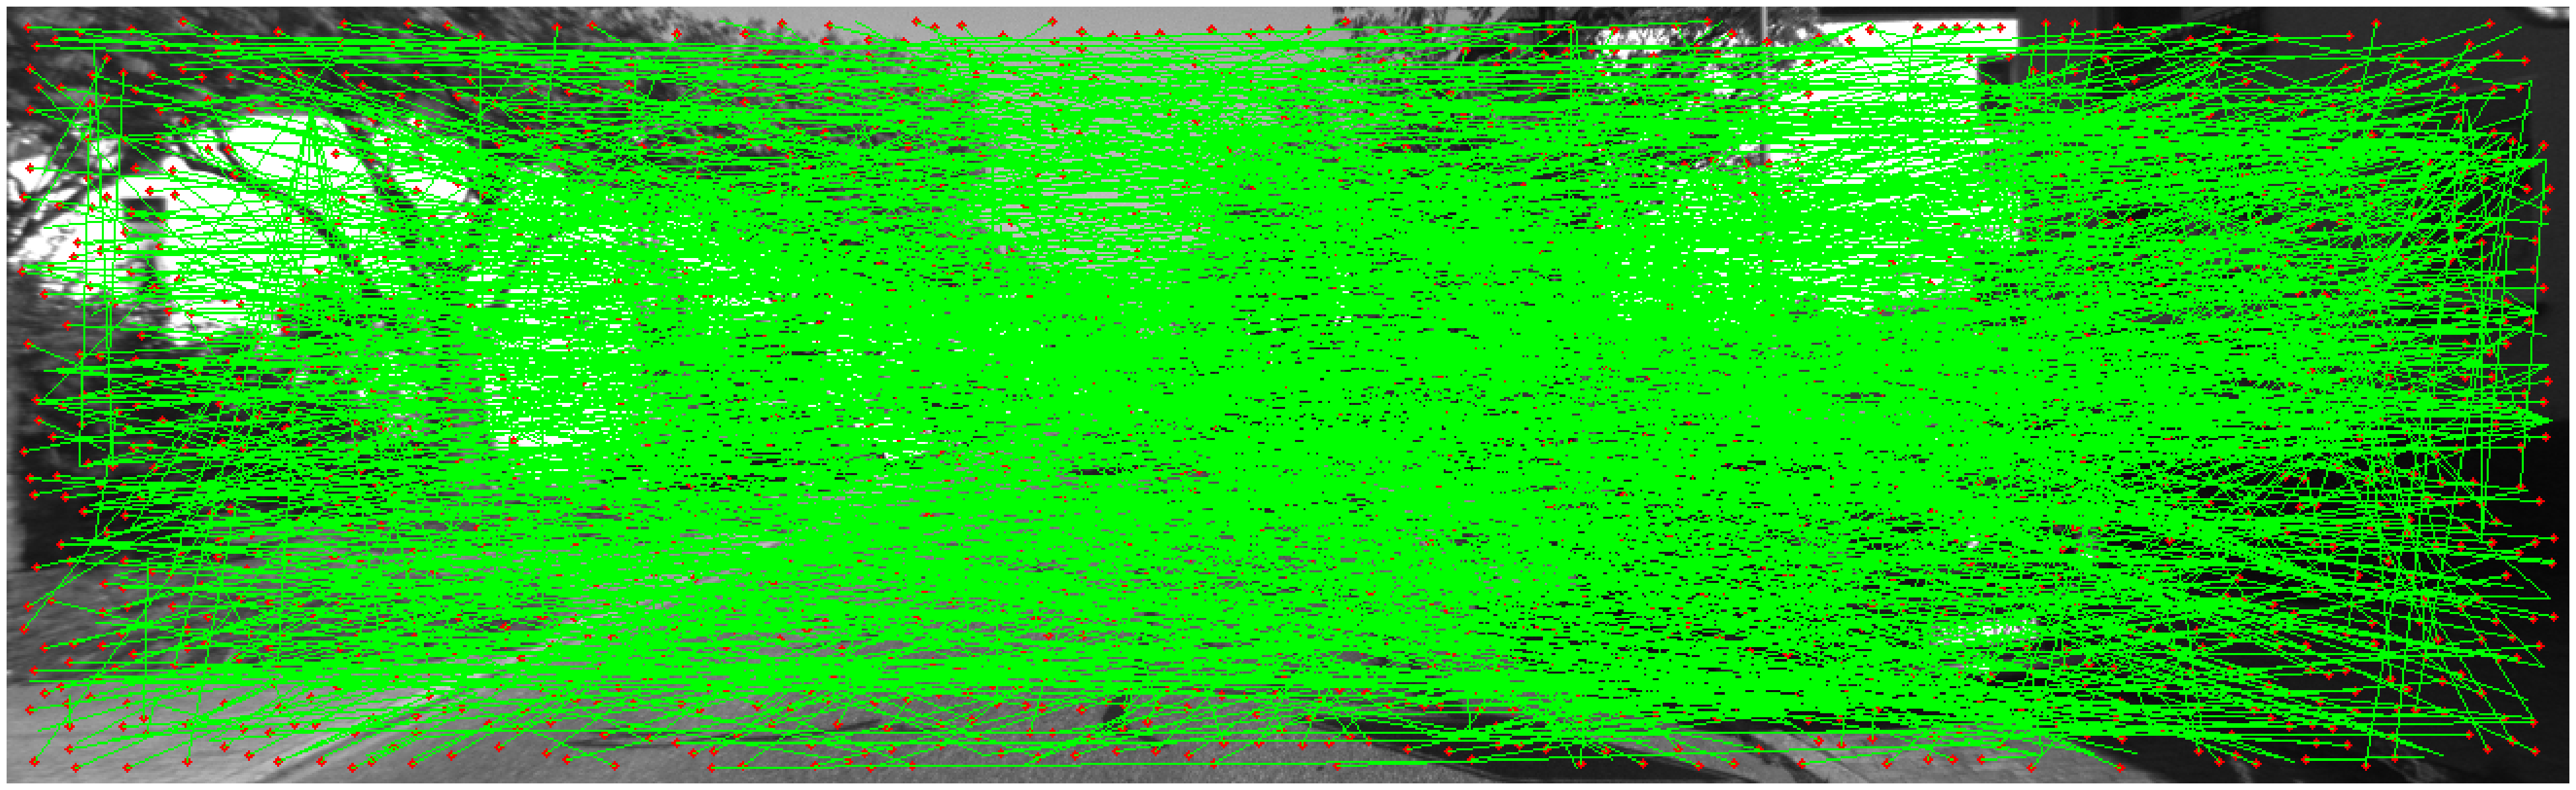

Done 3


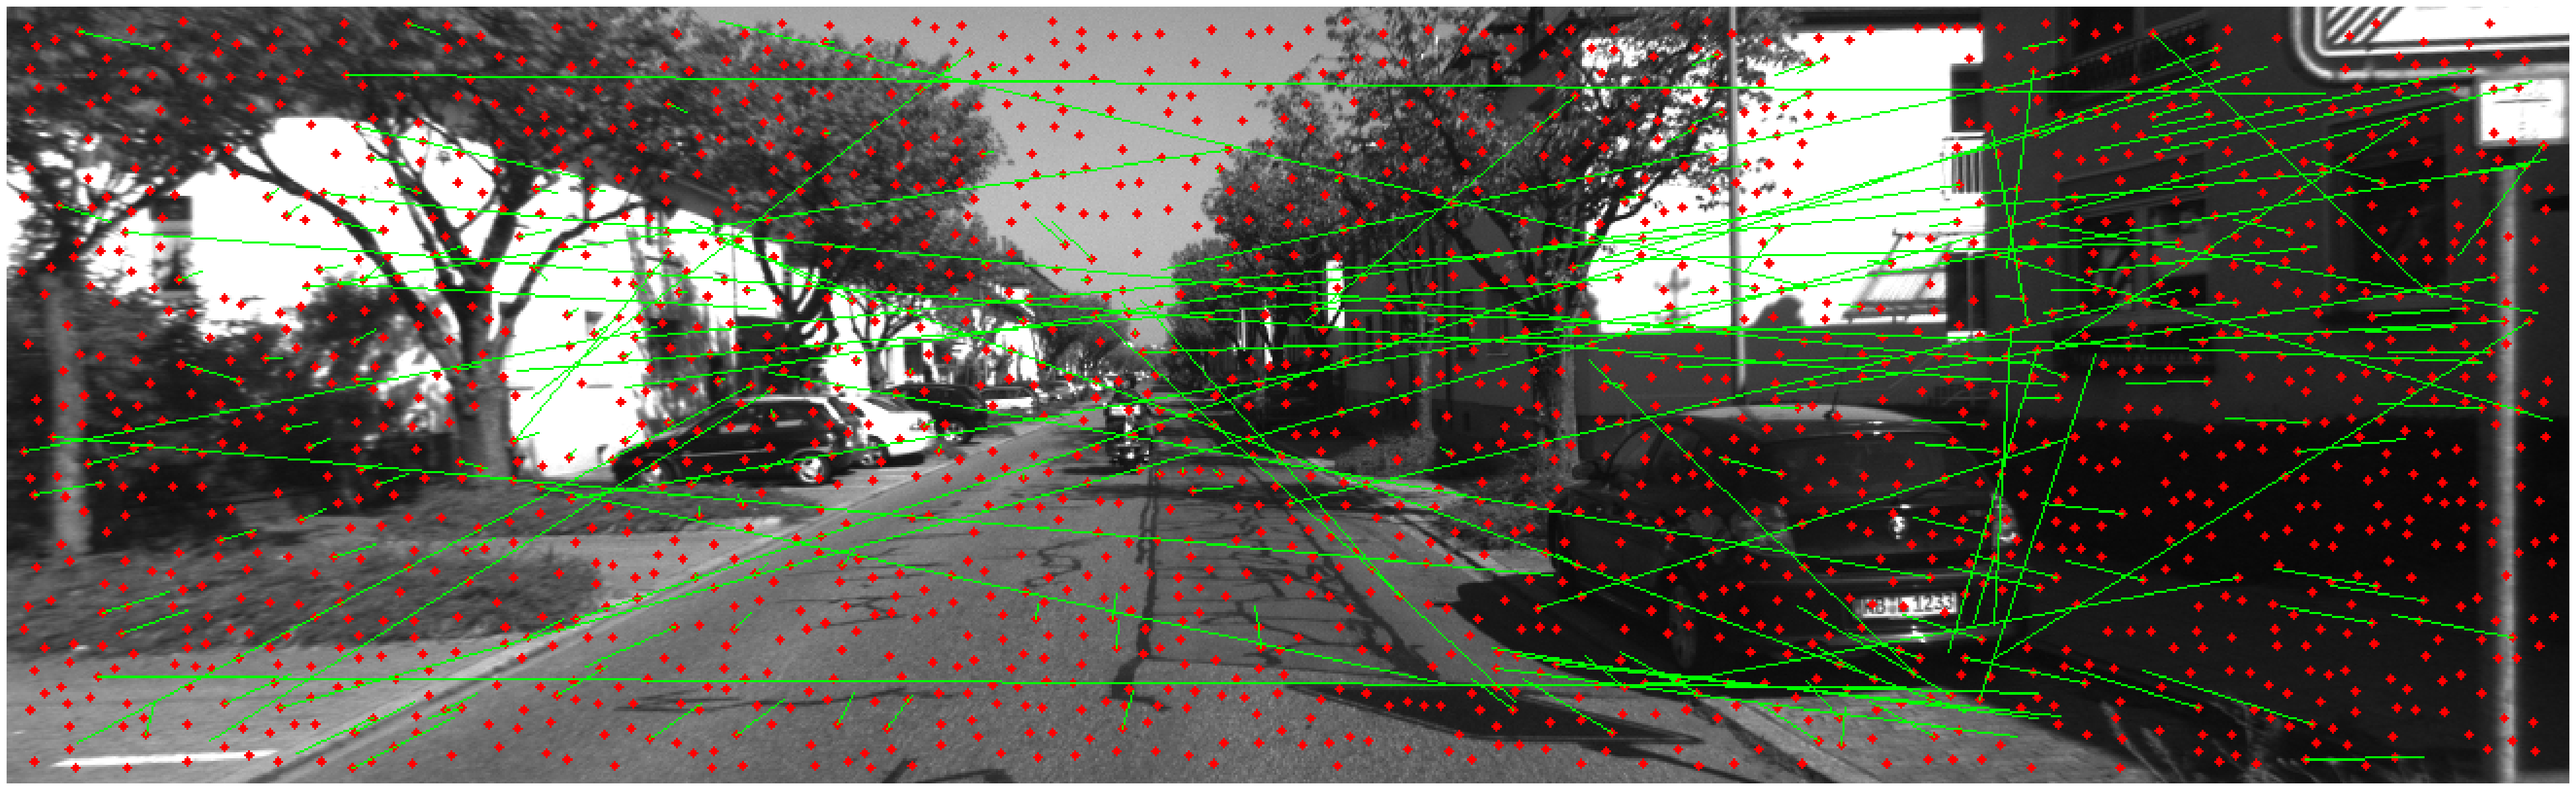

In [335]:
# Load two images
image1 = "images/000000.png"
image2 = "images/000001.png"

# Detect keypoints in both images using Harris Detector
image1, _, coordinates1 = test_harris_detector(image1)
image2, _, coordinates2 = test_harris_detector(image2)

# Extract patches and normalize them
normalized_patches1 = extract_normalized_patches(image1, coordinates1)
normalized_patches2 = extract_normalized_patches(image2, coordinates2)
print("DONE")

D = distance_matrix(normalized_patches1, normalized_patches2)
print("DONE")

matches = find_matches(D)
print('DONE 2')
matches_vis(image2, coordinates1, coordinates2, matches)

robust_matches = find_robust_matches(D)
print("Done 3")
matches_vis(image1, coordinates1, coordinates2, robust_matches)


## Saving of matches

This function is used to save the result of the match and vis function to a folder so that we can make a video later.

In [296]:
def matches_vis_save(image_tgt, list_keypoints_src, list_keypoints_tgt, matches, save_folder, image_number):
    # repeat channels for creating color image from grayscale
    image_color = cv2.merge([image_tgt, image_tgt, image_tgt]).astype(np.uint8)
    # add cross for each keypoint in target image
    for keyp in list_keypoints_tgt:
        cv2.drawMarker(image_color, (keyp[1], keyp[0]), (255, 0, 0),
        markerType = cv2.MARKER_CROSS, markerSize = 3, thickness = 2, 
        line_type = cv2.LINE_8)

    # draw green lines of matches
    for i, j in matches:
        coord_src, coord_tgt = list_keypoints_src[i], list_keypoints_tgt[j]
    # please note that coordinates are inverted to follow opencv convention (x, y)
    # instead of (y, x)
        cv2.line(image_color,
        (coord_tgt[1], coord_tgt[0]),
        (coord_src[1], coord_src[0]),
        (0, 255, 0),
        1)

    # remove whitespaces around the image
    plt.autoscale(tight=True)
    plt.axis("off")

    # set the figure size accordingly
    plt.figure(figsize=(image_color.shape[1]/100, image_color.shape[0]/100))
    plt.imshow(image_color)
    plt.axis("off")
    plt.savefig(os.path.join(save_folder, 'result_' + str(image_number) + '.png'), bbox_inches='tight', pad_inches=0)
    plt.close()

## Driver function for Corner Tracking with Patch Templates for images in the folder.

<br>
Professor this was a really time taking processes to find the distance between two images. It took almost 30 seconds to find distance between two patches.<br>
So for this reason, rather than using this function for 200 images, I only used first 50 images.<br>
I hope you understand

In [297]:
def process_images_intnesity_descriptor(image_folder):
    # Get a list of all image filenames in the folder
    filenames = sorted(os.listdir(image_folder))
    num_images = len(filenames)

    # Loop through all the images
    for i in range(num_images - 1):
        image1 = os.path.join(image_folder, filenames[i])
        image2 = os.path.join(image_folder, filenames[i + 1])
        
        # Detect keypoints in both images using Harris Detector
        image1, _, coordinates1 = test_harris_detector(image1)
        image2, _, coordinates2 = test_harris_detector(image2)

        # Extract patches and normalize them
        normalized_patches1 = extract_normalized_patches(image1, coordinates1)
        normalized_patches2 = extract_normalized_patches(image2, coordinates2)
        # print("DONE")

        D = distance_matrix(normalized_patches1, normalized_patches2)
        # print("DONE")

        matches = find_matches(D)
        # print('DONE 2')
        # matches_vis(image2, coordinates1, coordinates2, matches)

        robust_matches = find_robust_matches(D)
        print("Done 3")
        matches_vis_save(image2, coordinates1, coordinates2, robust_matches, 'output_4/', i)


In [298]:
image_folder = 'images/'
# process_images_intnesity_descriptor(image_folder)

# Part IV - Corner Tracking with SIFT Features
<br>
<br>
Using the built in function from OpenCV, now we will find the SIFT descriptors

In [336]:
def extract_sift_descriptors(image, keypoints):
    # Convert the keypoints list to a list of cv.KeyPoint objects
    keypoints = [cv2.KeyPoint(float(pt[1]), float(pt[0]), size=32, angle=0) for pt in keypoints]
    
    # Create an instance of the SIFT feature extractor
    sift = cv2.SIFT_create()
    
    # Compute the keypoints and descriptors
    kp, desc = sift.compute(image, keypoints)
    
    return kp, desc


# Driver Code

DONE
DONE
DONE 2


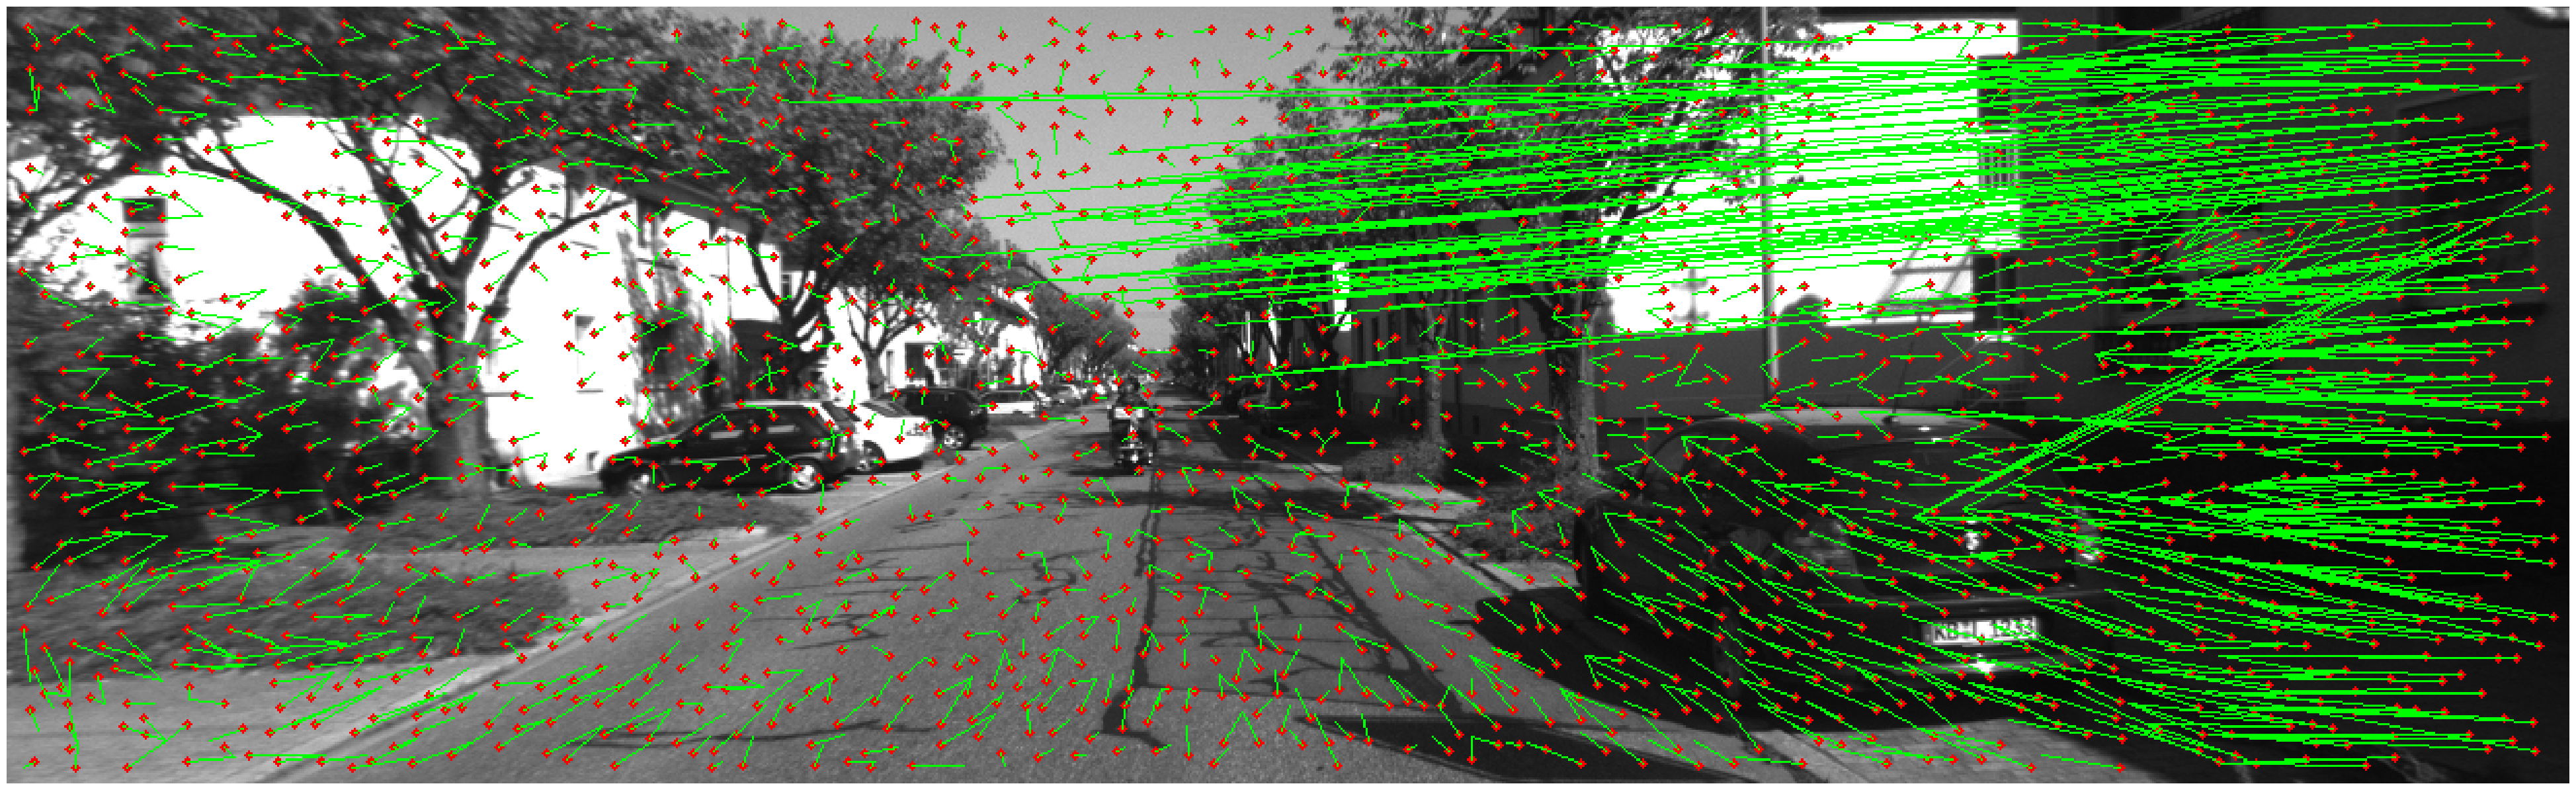

Done 3


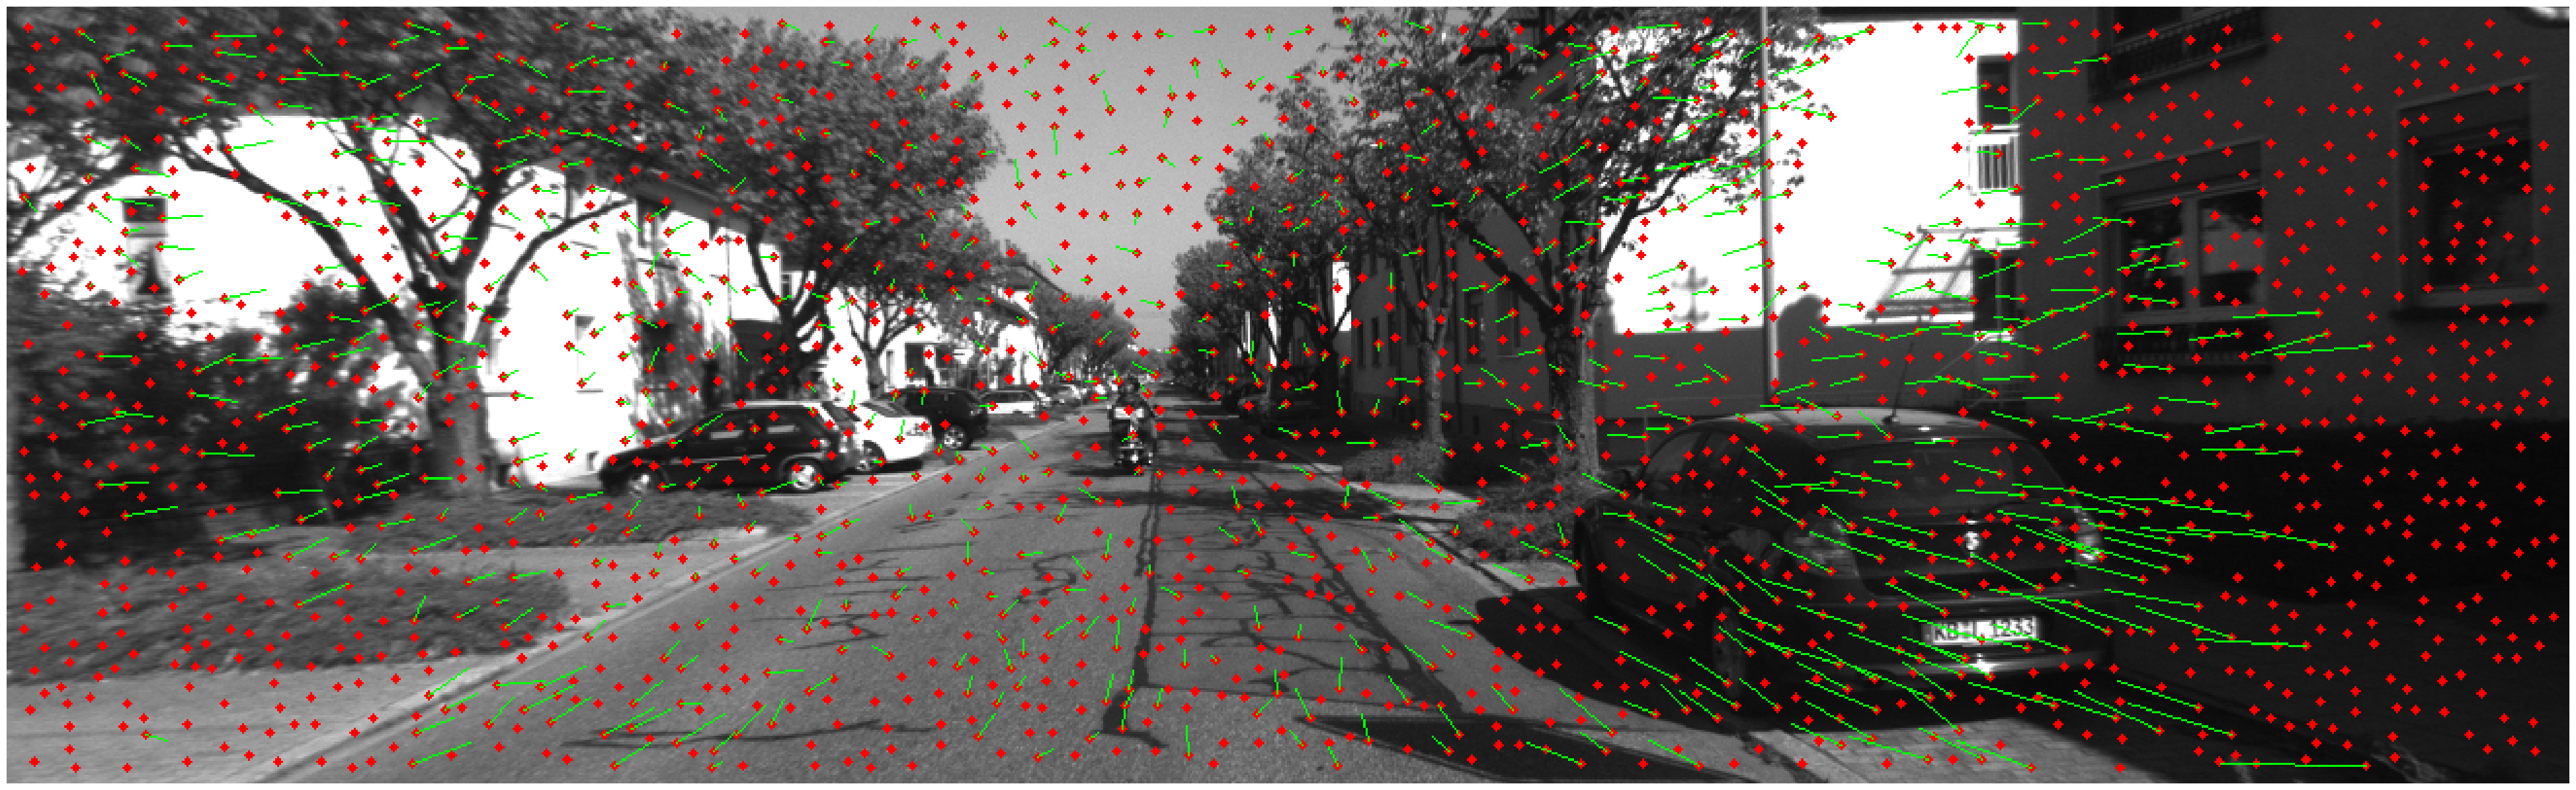

In [337]:
# Load two images
image1 = "images/000000.png"
image2 = "images/000001.png"

# Detect keypoints in both images using Harris Detector
image1, _, coordinates1 = test_harris_detector(image1)
image2, _, coordinates2 = test_harris_detector(image2)

keypoints1, descriptors1 = extract_sift_descriptors(image1, coordinates1)
keypoints2, descriptors2 = extract_sift_descriptors(image2, coordinates2)


print("DONE")

D = distance_matrix(descriptors1, descriptors2)
print("DONE")

matches = find_matches(D)
print('DONE 2')
matches_vis(image2, coordinates1, coordinates2, matches)

robust_matches = find_robust_matches(D)
print("Done 3")
matches_vis(image2, coordinates1, coordinates2, robust_matches)

## Driver function for Corner Tracking with SIFT Features for images in the folder.

<br>
Professor this was a really time taking processes to find the distance between two images. It took almost 20 seconds to find distance between two patches.<br>
So for this reason, rather than using this function for 200 images, I only used first 50 images.<br>
I hope you understand <br><br>
Visually, we can see that SIFT is much better than the Corner Tracking with Patch Templates

In [300]:
def process_images_SIFT_descriptor(image_folder):
    # Get a list of all image filenames in the folder
    filenames = sorted(os.listdir(image_folder))
    num_images = len(filenames)

    # Loop through all the images
    for i in range(num_images - 1):

        image1 = os.path.join(image_folder, filenames[i])
        image2 = os.path.join(image_folder, filenames[i + 1])
        # Detect keypoints in both images using Harris Detector
        image1, _, coordinates1 = test_harris_detector(image1)
        image2, _, coordinates2 = test_harris_detector(image2)

        keypoints1, descriptors1 = extract_sift_descriptors(image1, coordinates1)
        keypoints2, descriptors2 = extract_sift_descriptors(image2, coordinates2)


        D = distance_matrix(descriptors1, descriptors2)

        robust_matches = find_robust_matches(D)
        print("Done", i+1)
        matches_vis_save(image2, coordinates1, coordinates2, robust_matches, 'output_5/', i)


In [301]:
image_folder = 'images/'
# process_images_SIFT_descriptor(image_folder)

Code for making Videos

In [ ]:
output_folder = 'output_5/'
count = count_images_in_folder(output_folder)

output_path = 'output_video_SIFT.mp4'
create_video(output_folder, output_path, fps=3)

# Part V - Corner Tracking with Prior Motion Fitting Model

Professor I am facing some issues in this, so I could not make the video for this part but bellow you can find the main functions for this part.

In [302]:
def estimate_homography(previous_frame, current_frame, method=cv2.RANSAC):
    """
    Estimate the homography transformation between two frames.
    """
    previous_corners = non_max_suppression(harris_response(*gradient_images(remove_noise(rgb2gray(previous_frame)))))
    current_corners = non_max_suppression(harris_response(*gradient_images(remove_noise(rgb2gray(current_frame)))))
    # Find the corresponding points between the previous frame and the current frame
    previous_points = np.float32([previous_corners[i] for i in range(len(previous_corners))]).reshape(-1,1,2)
    current_points = np.float32([current_corners[i] for i in range(len(current_corners))]).reshape(-1,1,2)
    # Use the OpenCV function cv.findHomography to estimate the homography transformation
    M, mask = cv2.findHomography(previous_points, current_points, method, 5.0)
    # Return the mask that specifies which inliers were found
    return M, mask

def estimate_affine_transform(previous_frame, current_frame, method=cv2.RANSAC):
    """
    Estimate the affine transformation between two frames.
    """
    previous_corners = non_max_suppression(harris_response(*gradient_images(remove_noise(rgb2gray(previous_frame)))))
    current_corners = non_max_suppression(harris_response(*gradient_images(remove_noise(rgb2gray(current_frame)))))
    # Find the corresponding points between the previous frame and the current frame
    previous_points = np.float32([previous_corners[i] for i in range(len(previous_corners))]).reshape(-1,1,2)
    current_points = np.float32([current_corners[i] for i in range(len(current_corners))]).reshape(-1,1,2)
    # Use the OpenCV function cv.getAffineTransform to estimate the affine transformation
    M = cv2.getAffineTransform(previous_points, current_points)
    return M